In [25]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations

from news_vec.corpus import Corpus

from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [16]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-28 17:00:38,728 | INFO : Reading headlines.
1225511it [00:23, 53116.06it/s]


In [17]:
corpus.df = corpus.df[corpus.df.clf_tokens.apply(lambda ts: 'trump' in ts)][corpus.df.domain.isin(['cnn.com', 'foxnews.com', 'nytimes.com', 'apnews.com'])]

/Users/dclure/.local/share/virtualenvs/news-vec-AvAtlVxK/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [19]:
def a_vs_b(a, b, n=10, verbose=True):
    
    df = corpus.sample_ab(a, b)
    
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )
    
    clf = LinearSVC()
    
    X = tv.fit_transform(df.clf_tokens)
    
    return cross_val_score(clf, X, df.domain, cv=n, n_jobs=-1, verbose=verbose)

In [22]:
a_vs_b('nytimes.com', 'foxnews.com', 100)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished


array([0.76724138, 0.75      , 0.8362069 , 0.80172414, 0.69827586,
       0.72413793, 0.73275862, 0.76724138, 0.75      , 0.65517241,
       0.81034483, 0.84482759, 0.82758621, 0.78448276, 0.79310345,
       0.79310345, 0.77586207, 0.79310345, 0.6637931 , 0.78448276,
       0.84482759, 0.79310345, 0.75      , 0.75862069, 0.79310345,
       0.77586207, 0.75862069, 0.74137931, 0.81034483, 0.81896552,
       0.69827586, 0.73275862, 0.81896552, 0.79310345, 0.81034483,
       0.75      , 0.73275862, 0.81034483, 0.78448276, 0.79310345,
       0.8245614 , 0.72807018, 0.75438596, 0.80701754, 0.80701754,
       0.79824561, 0.83333333, 0.8245614 , 0.74561404, 0.84210526,
       0.83333333, 0.6754386 , 0.83333333, 0.78947368, 0.8245614 ,
       0.84210526, 0.79824561, 0.84210526, 0.8245614 , 0.78947368,
       0.84210526, 0.80701754, 0.79824561, 0.78070175, 0.78947368,
       0.74561404, 0.79824561, 0.80701754, 0.84210526, 0.9122807 ,
       0.78947368, 0.79824561, 0.79824561, 0.8245614 , 0.78070

In [23]:
domains = corpus.df.domain.unique()

In [26]:
pairs = list(combinations(domains, 2))

In [27]:
rows = []
for a, b in tqdm(pairs):
    scores = a_vs_b(a, b, 100, verbose=False)
    for s in scores:
        rows.append((a, b, s))

100%|██████████| 6/6 [00:43<00:00,  7.22s/it]


In [28]:
score_df = pd.DataFrame(rows, columns=('d1', 'd2', 'acc'))

In [29]:
score_df['pair'] = score_df[['d1', 'd2']].apply(lambda x: f'{x[0]} - {x[1]}', axis=1)

In [30]:
score_df.head(10)

,d1,d2,acc,pair
0,cnn.com,nytimes.com,0.681034,cnn.com - nytimes.com
1,cnn.com,nytimes.com,0.741379,cnn.com - nytimes.com
2,cnn.com,nytimes.com,0.689655,cnn.com - nytimes.com
3,cnn.com,nytimes.com,0.706897,cnn.com - nytimes.com
4,cnn.com,nytimes.com,0.741379,cnn.com - nytimes.com
5,cnn.com,nytimes.com,0.750000,cnn.com - nytimes.com
6,cnn.com,nytimes.com,0.750000,cnn.com - nytimes.com
7,cnn.com,nytimes.com,0.784483,cnn.com - nytimes.com
8,cnn.com,nytimes.com,0.698276,cnn.com - nytimes.com
9,cnn.com,nytimes.com,0.724138,cnn.com - nytimes.com


In [31]:
len(score_df)

600

In [32]:
order = score_df.groupby('pair').mean().acc.sort_values(ascending=False).index

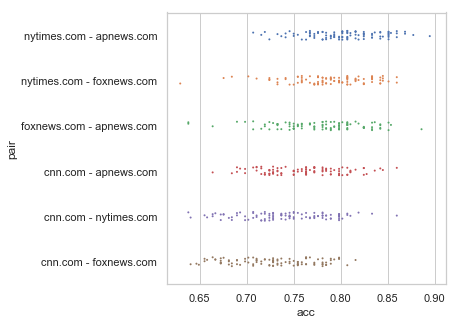

In [34]:
plt.figure(figsize=(5,5))
sns.stripplot(x='acc', y='pair', data=score_df, order=order, s=2)